In [2]:
cd pyDDM

/Users/sam/Documents/GitHub/pyDDM/pyDDM


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from bioviper import msa, pdb
from ddm import DDM, align_structures, helix_bin

from scipy import spatial
from scipy.cluster import hierarchy
from sklearn.decomposition import PCA, SparsePCA, NMF

from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap

from scipy.spatial.distance import squareform

#so that the pdfs produced are compatible with Adobe Illustrator
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams["font.sans-serif"] = "Arial"

helix_names = ['1a','1b','2','3','4','5a','5b','6a','6b','7','8','9','10a','10b']

def selector(df, dic):

    '''A little tool for selecting from pandas dataframes by passing a dictionary, e.g.
            selector(df, {"color":"red", "shape":["square", "circle"]})
        
        For advanced usage, you can pass a function and it will return where True, e.g.
            selector(df, ["name": lambda name: "Sam" in name])
            
        You can also use this to select things greater than or less than a value, e.g.
            selector(df, ["enrichment": lambda enr: enr > 1])'''
    
    X = df.copy()

    for key,val in dic.items():
        
        # If you pass a tuple, list or numpy array
        if isinstance(val, (tuple, list, np.ndarray)):
            where = np.any(np.array([X[key]==v for v in val]),axis=0)
            X = X.loc[where]
            
        # If you pass a function
        elif isinstance(val, type(lambda x: x+1)):
            X = X.loc[X[key].apply(val)]
            
        # Otherwise we assume it's a single value
        else:
            X = X.loc[X[key]==val]

    return X

def DDM_linkage_cluster(D, helix_names=None, method='average', plot=True,
                       dendrogram_ratio=0.3, colormap='Greys', figsize=(5,5)):
    
    # Conver the DDM into a "proper" distance matrix
    for i in range(14):
        for j in range(i,14):
            
            # We need to sadly make the diagonals into zeros
            if i==j:
                D[(i,j)] = 0
                
            # Fix numerical errors that make it not technically symmetric
            elif D[(i,j)] != D[(j,i)]:
                D[(i,j)] = D[(j,i)]
                
    linkage = hierarchy.linkage(squareform(D), method=method, optimal_ordering=True)
    
    if plot:
        if type(helix_names) == type(None):
            print("Must pass helix names to plot!")
        else:
            Ddf = pd.DataFrame(D, columns=helix_names)
            Ddf.index = helix_names
            cg = sns.clustermap(Ddf, row_linkage=linkage, col_linkage=linkage, cmap=colormap, figsize=figsize,
              dendrogram_ratio=dendrogram_ratio, vmin=0, vmax=8)
            
            plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
            plt.setp(cg.ax_heatmap.xaxis.get_majorticklabels(), rotation=90)
            
    return linkage

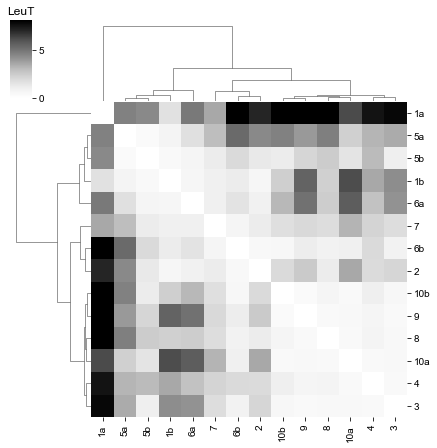

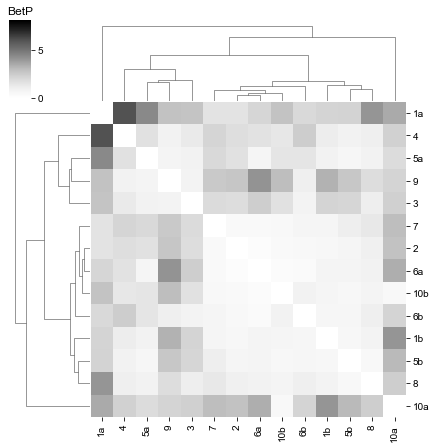

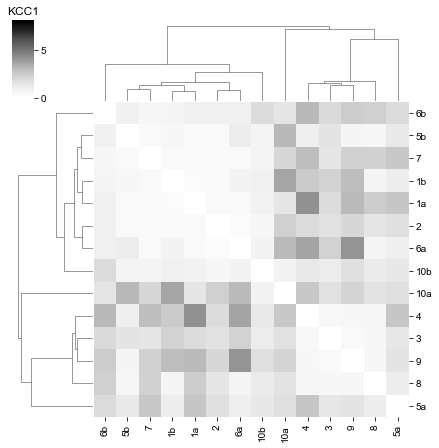

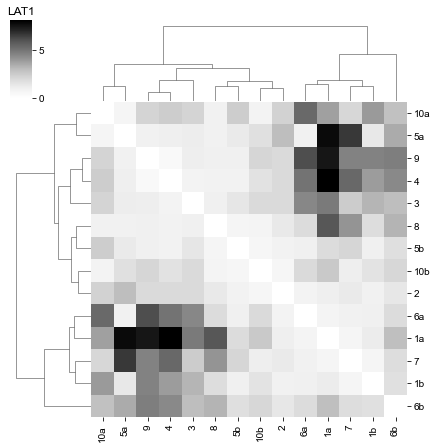

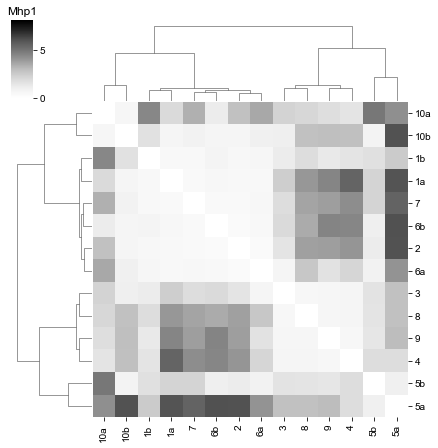

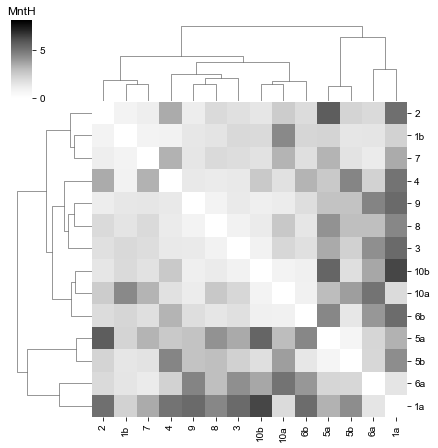

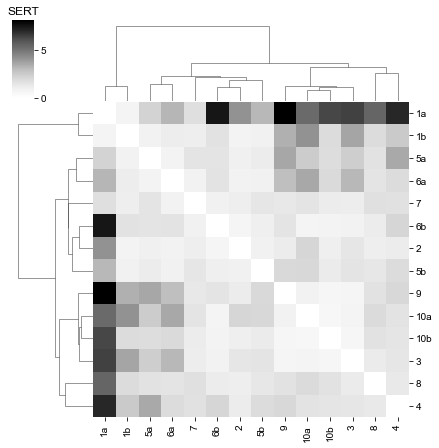

In [12]:
plt.rcParams.update({'font.size': 10})

hb_ddms = np.load("../data/hb_ddms.npy", allow_pickle=True).item()
all_transitions = pd.read_csv("../data/all_transitions.csv")
all_hb_ddms = np.array([hbddm for key,hbddm in hb_ddms.items()])

for D,pn in zip(all_hb_ddms[all_transitions["transition"]=='$O_{op}$ → $I_{op}$'], all_transitions["name"][all_transitions["transition"]=='$O_{op}$ → $I_{op}$']):

    DDM_linkage_cluster(D, helix_names=helix_names, method='average', figsize=(6,6), dendrogram_ratio=0.2)
    plt.title(pn)
    
    plt.xticks(rotation=90)
    
    #plt.savefig("clustermaps/" + pn + "_Oop_Iop_average_same_scale.pdf", bbox_inches="tight")